In [ ]:
# Install the required libraries
!pip install torch torchvision matplotlib opencv-python


In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

model_type = "DPT_Large"
model = torch.hub.load("intel-isl/MiDaS", model_type)
model.eval()
transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180 (from 1)
Receiving objects: 100% (180/180), 10.27 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
%cd nianticlabs/monodepth2

[Errno 2] No such file or directory: 'nianticlabs/monodepth2'
/content/monodepth2/monodepth2


In [ ]:
from google.colab import files
uploaded = files.upload()

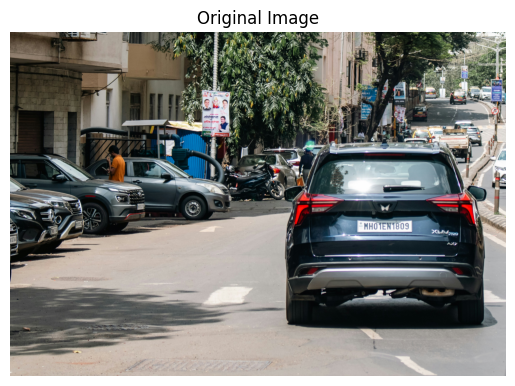

In [ ]:
image_file = list(uploaded.keys())[0]
image = Image.open(image_file)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


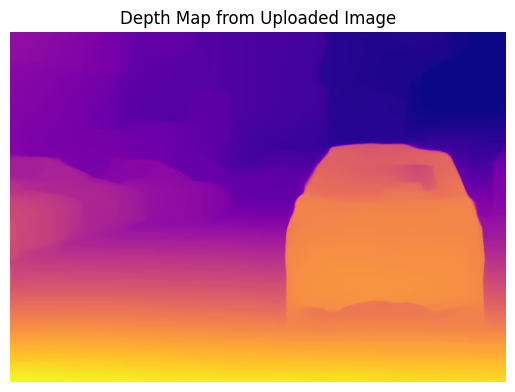

In [ ]:
# DPT
if model_type.startswith("DPT"):
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform
else:
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# Upload the image
# uploaded = files.upload()

# Get the first uploaded image file
image_file = list(uploaded.keys())[0]  # Extract the file name

# Open the image using PIL
image = Image.open(image_file)

# Apply the transformation (resize, normalize, etc.)
# Convert the PIL Image to a NumPy array
image_np = np.array(image)
# Ensure the image has 3 channels (RGB)
if image_np.ndim == 2:  # If grayscale, convert to RGB
    image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
elif image_np.shape[2] == 4:  # If RGBA, convert to RGB
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)

input_tensor = transform(image_np).unsqueeze(0)  # Normalizing the image to [0, 1] and adding batch dimension
input_tensor = input_tensor.squeeze(1)

# Run the model
with torch.no_grad():
    # Get the depth prediction from MiDaS
    prediction = model(input_tensor)

    # Convert the prediction to a depth map
    depth_map = prediction.squeeze().cpu().numpy()

    # Normalize the depth map for better visualization
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Display the depth map
    plt.imshow(depth_map, cmap="plasma")
    plt.title("Depth Map from Uploaded Image")
    plt.axis("off")
    plt.show()

In [ ]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Saving output008178_(vehicle.get_control().steer).jpg to output008178_(vehicle.get_control().steer).jpg


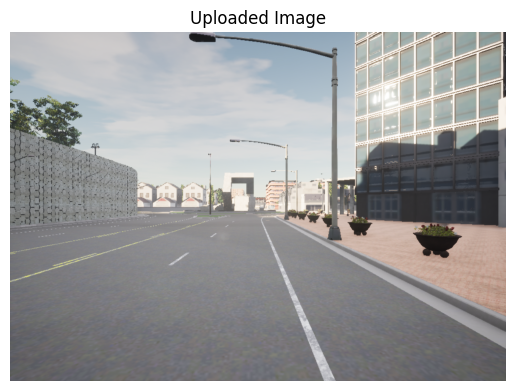

In [ ]:
from google.colab import files
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = Image.open(image_path)
plt.imshow(image)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

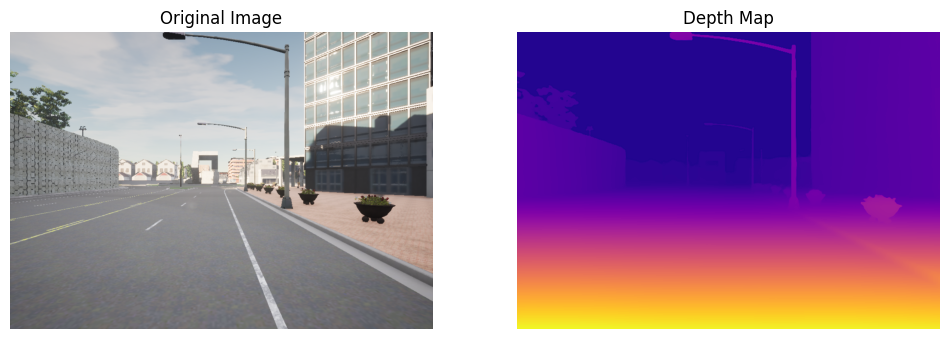

In [ ]:
# Depth AnyThing
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

# # Load the image processor and model
image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
image = image.convert("RGB")
# Prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

# Perform inference without computing gradients (no need for backpropagation)
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the depth estimation
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],  # Resize the depth map to match the image size
)

# Extract predicted depth
predicted_depth = post_processed_output[0]["predicted_depth"]

# Normalize the depth map to be between 0 and 1
depth = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())

# Convert depth to an 8-bit image (0-255 range) for visualization
depth = depth.detach().cpu().numpy() * 255
depth = Image.fromarray(depth.astype("uint8"))

# Display the original image and the depth map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

# Display the depth map
ax2.imshow(depth, cmap='plasma')
ax2.set_title("Depth Map")
ax2.axis('off')

plt.show()
